In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Flatten, Add, Dropout, Conv2D, BatchNormalization, Activation, Concatenate
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, multiply, add
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K


In [2]:
# data preparation
dataset_dir =  r'D:\Project\Deep Learning - Research\programs\MV-couswork\Brain Tumor Data Set\BrainTumorProcessed'
input_shape = (256, 256, 3)
batch_size = 2
num_classes = 2

In [3]:
# data augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

test_datagen = ImageDataGenerator(
rescale = 1./255
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 3103 images belonging to 2 classes.
Found 665 images belonging to 2 classes.
Found 666 images belonging to 2 classes.


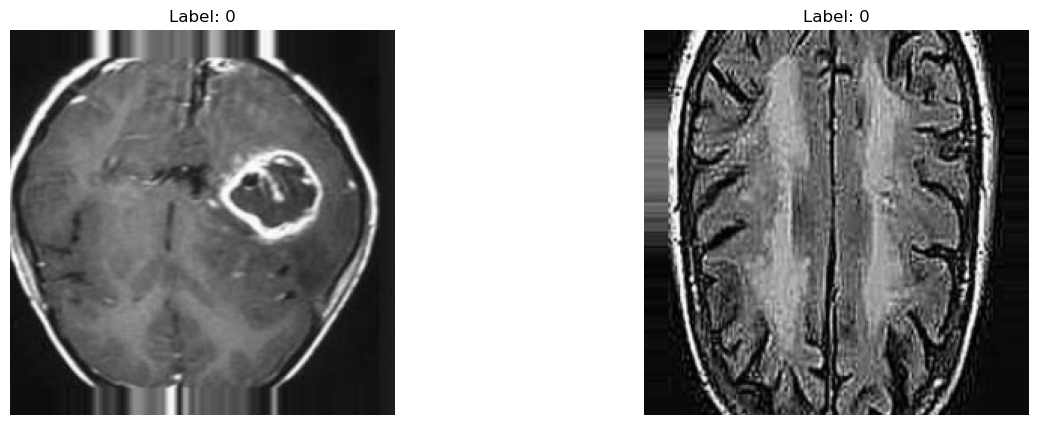

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
def residual_block(inputs, num_filter):
    # Convolution layers
    x = Conv2D(num_filter, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(num_filter, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(2*num_filter, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(2*num_filter, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Skip connection
    if inputs.shape[-1] != num_filter:
        shortcut = Conv2D(2*num_filter, kernel_size=(1,1), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut=inputs
        
    shortcut = MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(shortcut)
    # add skip connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [7]:
def cbam_block(cbam_feature, ratio=8):
    # Channel Attention Module
    channel_avg = GlobalAveragePooling2D()(cbam_feature)
    channel_max = GlobalAveragePooling2D()(cbam_feature)
    channel_avg = Reshape((1, 1, K.int_shape(cbam_feature)[-1]))(channel_avg)
    channel_max = Reshape((1, 1, K.int_shape(cbam_feature)[-1]))(channel_max)
    channel_avg = Dense(K.int_shape(cbam_feature)[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(channel_avg)
    channel_max = Dense(K.int_shape(cbam_feature)[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(channel_max)
    channel_avg = Dense(K.int_shape(cbam_feature)[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(channel_avg)
    channel_max = Dense(K.int_shape(cbam_feature)[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(channel_max)
    channel_attention = multiply([cbam_feature, channel_avg + channel_max])

    # Spatial Attention Module
    spatial_avg = K.mean(channel_attention, axis=-1, keepdims=True)
    spatial_max = K.max(channel_attention, axis=-1, keepdims=True)
    spatial_attention = add([spatial_avg, spatial_max])
    spatial_attention = Activation('sigmoid')(spatial_attention)

    return multiply([channel_attention, spatial_attention])


In [8]:
 def VGG_residual(inputs_shape):    
    inputs = Input(shape=input_shape)
    
    x = residual_block(inputs, 64) # 2 conv layers
    
    x = cbam_block(x)
    
    x = residual_block(x, 256) # 2 conv layers
    
    x = cbam_block(x)
    
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Flatten the layers
#     x = Flatten()(x)

#     # Add fully connected layers
#     x = Dense(units=2048, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     x = Dense(units=2048, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     output = Dense(1, activation='sigmoid')(x)  # Third fully connected layer

    x = Conv2D(4096, (1,1), activation='relu')(x)

    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model


In [9]:
model = VGG_residual(input_shape)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [11]:

model.compile(loss='binary_crossentropy', optimizer='adaGrad', metrics=['accuracy'])

In [12]:
history = model.fit(train_generator, epochs=60, validation_data =(validation_generator), verbose=1)

Epoch 1/60
1552/1552 [==============================] - 63s 37ms/step - loss: 0.6862 - accuracy: 0.5498 - val_loss: 0.6613 - val_accuracy: 0.6481
Epoch 2/60
1552/1552 [==============================] - 57s 37ms/step - loss: 0.6674 - accuracy: 0.6039 - val_loss: 0.6623 - val_accuracy: 0.6150
Epoch 3/60
1552/1552 [==============================] - 57s 37ms/step - loss: 0.6325 - accuracy: 0.6420 - val_loss: 0.6185 - val_accuracy: 0.6541
Epoch 4/60
1552/1552 [==============================] - 57s 37ms/step - loss: 0.5892 - accuracy: 0.6793 - val_loss: 0.6029 - val_accuracy: 0.6962
Epoch 5/60
1552/1552 [==============================] - 57s 37ms/step - loss: 0.5487 - accuracy: 0.7254 - val_loss: 0.5597 - val_accuracy: 0.7338
Epoch 6/60
1552/1552 [==============================] - 57s 37ms/step - loss: 0.5200 - accuracy: 0.7409 - val_loss: 0.5230 - val_accuracy: 0.7308
Epoch 7/60
1552/1552 [==============================] - 57s 37ms/step - loss: 0.4913 - accuracy: 0.7573 - val_loss: 0.4867 -

Epoch 57/60
1552/1552 [==============================] - 56s 36ms/step - loss: 0.0736 - accuracy: 0.9720 - val_loss: 0.1715 - val_accuracy: 0.9398
Epoch 58/60
1552/1552 [==============================] - 56s 36ms/step - loss: 0.0714 - accuracy: 0.9755 - val_loss: 0.1870 - val_accuracy: 0.9474
Epoch 59/60
1552/1552 [==============================] - 56s 36ms/step - loss: 0.0667 - accuracy: 0.9765 - val_loss: 0.2091 - val_accuracy: 0.9444
Epoch 60/60
1552/1552 [==============================] - 56s 36ms/step - loss: 0.0757 - accuracy: 0.9713 - val_loss: 0.1986 - val_accuracy: 0.9474


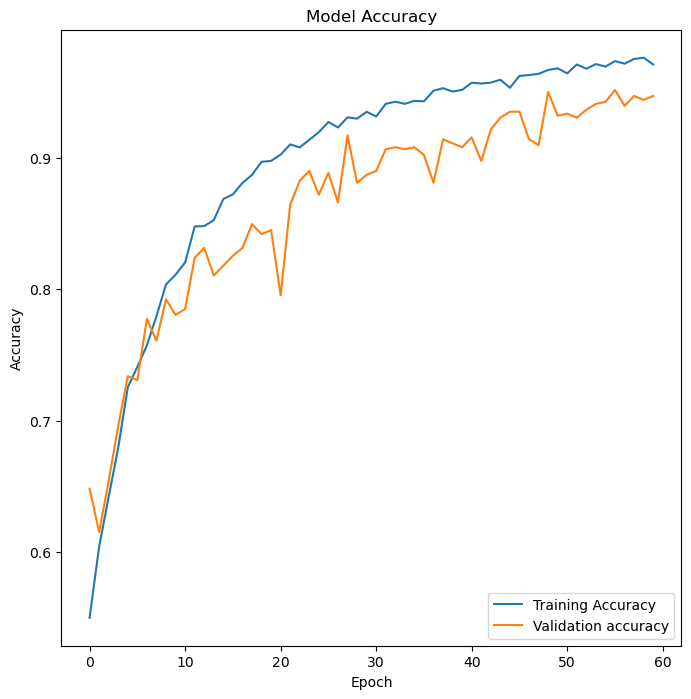

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation accuracy'], loc='lower right')

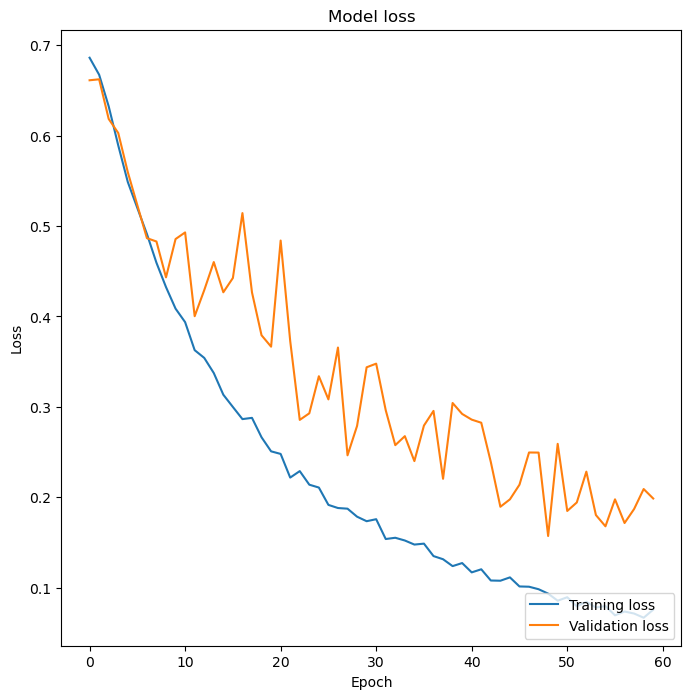

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], loc='lower right')
plt.show()

In [15]:
loss, accurancy = model.evaluate(test_generator)
print('Test loss:', loss)
print("Test accurancy", accurancy)

333/333 [==============================] - 5s 14ms/step - loss: 0.2364 - accuracy: 0.9294
Test loss: 0.23643644154071808
Test accurancy 0.9294294118881226


In [16]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

#Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

#compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[188 166]
 [179 133]]


In [17]:
#compute f1-score
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred_labels)
print('F1-score:', f1)

F1-score: 0.4353518821603928


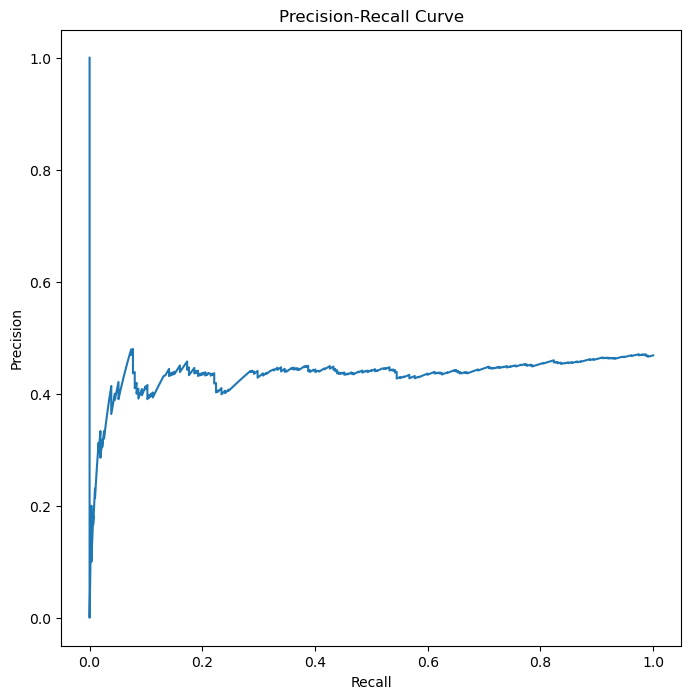

In [18]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

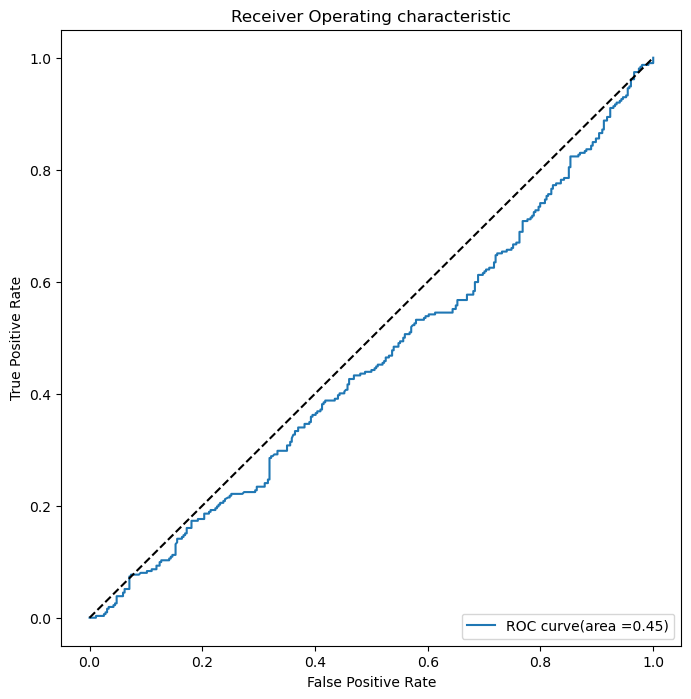

In [19]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [20]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 0.9971751412429378


In [21]:
model.save("vra.h5")

C:\Users\hibition\.conda\envs\tensorflow_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
